In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mode
# import pandas_profiling
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,KFold
from sklearn.metrics import classification_report,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.metrics import auc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth',500)
pd.set_option('display.max_columns',5000)

encoder = LabelEncoder()
from IPython.display import Image
import os
!ls ../input/

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
pip install openpyxl


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
data = pd.read_excel('SBA_National-Final.xlsx')

In [5]:
data['NAICS'] = data['NAICS'].apply(lambda x: int(str(x)[:2]))

In [6]:
for dataset in [data]:
    dataset.loc[(dataset['MIS_Status']) == 'P I F', 'MIS_Status'] = 0
    dataset.loc[(dataset['MIS_Status']) == 'CHGOFF', 'MIS_Status'] = 1

In [7]:
for dataset in [data]:
    dataset['ChgOffDate'].fillna(0, inplace=True)  # Sửa các giá trị NaN thành 0
    dataset.loc[(dataset['ChgOffDate']) != 0, 'ChgOffDate'] = 1  # Sửa các giá trị khác NaN thành 1

Phân loại thời hạn vay tính theo tháng:
Vay ngắn hạn (1-12)
Vay trung hạn (13-60)
Vay dài hạn (>60)

In [8]:
for dataset in [data]:
    dataset.loc[((dataset['Term'] >=0 ) & (dataset['Term'] <=12)), 'Term'] = 1
    dataset.loc[((dataset['Term'] >=13 ) & (dataset['Term'] <=60)), 'Term'] = 2
    dataset.loc[((dataset['Term'] >60 )),'Term'] = 3

In [9]:
for dataset in [data]:
    dataset.loc[((dataset['NoEmp'] >=0 ) & (dataset['NoEmp'] <=4)), 'NoEmp'] = 1
    dataset.loc[((dataset['NoEmp'] >=5 ) & (dataset['NoEmp'] <=9)), 'NoEmp'] = 2
    dataset.loc[((dataset['NoEmp'] >=10 ) & (dataset['NoEmp'] <=19)), 'NoEmp'] = 3
    dataset.loc[((dataset['NoEmp'] >=20 ) & (dataset['NoEmp'] <=49)), 'NoEmp'] = 4
    dataset.loc[((dataset['NoEmp'] >=50 ) & (dataset['NoEmp'] <=99)), 'NoEmp'] = 5
    dataset.loc[((dataset['NoEmp'] >=100 ) & (dataset['NoEmp'] <=249)), 'NoEmp'] = 6
    dataset.loc[((dataset['NoEmp'] >=250 ) & (dataset['NoEmp'] <=499)), 'NoEmp'] = 7
    dataset.loc[((dataset['NoEmp'] >=500 ) & (dataset['NoEmp'] <=999)), 'NoEmp'] = 8
    dataset.loc[((dataset['NoEmp'] >1000 )),'NoEmp'] = 9

In [10]:
# for dataset in [data]:
#     dataset.loc[((dataset['DisbursementGross'] >=0 ) & (dataset['DisbursementGross'] <=20000)), 'DisbursementGross'] = 0
#     dataset.loc[((dataset['DisbursementGross'] >20000 ) & (dataset['DisbursementGross'] <=40000)), 'DisbursementGross'] = 1
#     dataset.loc[((dataset['DisbursementGross'] >40000 )),'DisbursementGross'] = 2

In [11]:
# for dataset in [data]:
#     dataset.loc[((dataset['GrAppv'] >=0 ) & (dataset['GrAppv'] <=50000)), 'GrAppv'] = 0
#     dataset.loc[((dataset['GrAppv'] >50000 ) & (dataset['GrAppv'] <=200000)), 'GrAppv'] = 1
#     dataset.loc[((dataset['GrAppv'] >200000 )),'GrAppv'] = 2

Phân loại dựa trên khoản vay:
Microloans < 50,000$
7(a) loans: 50,000$ - 5,000,000$
504 loans: 5,000,000$ - 5,500,000$


In [12]:
for dataset in [data]:
    dataset.loc[((dataset['SBA_Appv'] >=0 ) & (dataset['SBA_Appv'] <=50000)), 'SBA_Appv'] = 1
    dataset.loc[((dataset['SBA_Appv'] >50000 ) & (dataset['SBA_Appv'] <=5000000)), 'SBA_Appv'] = 2
    dataset.loc[((dataset['SBA_Appv'] >5000000 ) & (dataset['SBA_Appv'] <=5500000)), 'SBA_Appv'] = 3

In [13]:
data

,LoanNr_ChkDgt,Name,City,State,Bank,BankState,NAICS,ApprovalDate,Term,NoEmp,NewExist,UrbanRural,ChgOffDate,DisbursementDate,DisbursementGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,FIFTH THIRD BANK,OH,45,28-Feb-97,3,1,2,0,0,28-Feb-99,60000,0,0,60000,1
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,1ST SOURCE BANK,IN,72,28-Feb-97,2,1,2,0,0,31-May-97,40000,0,0,40000,1
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,GRANT COUNTY STATE BANK,IN,62,28-Feb-97,3,2,1,0,0,31-Dec-97,287000,0,0,287000,2
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,2,1,1,0,0,30-Jun-97,35000,0,0,35000,1
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,3,3,1,0,0,14-May-97,229000,0,0,229000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893287,9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,JPMORGAN CHASE BANK NATL ASSOC,IL,45,27-Feb-97,2,2,1,0,0,30-Sep-97,70000,0,0,70000,2
893288,9995603000,FABRIC FARMS,COLUMBUS,OH,JPMORGAN CHASE BANK NATL ASSOC,IL,45,27-Feb-97,2,2,1,0,0,31-Oct-97,85000,0,0,85000,1
893289,9995613003,"RADCO MANUFACTURING CO.,INC.",SANTA MARIA,CA,"RABOBANK, NATIONAL ASSOCIATION",CA,33,27-Feb-97,3,4,1,0,0,30-Sep-97,300000,0,0,300000,2
893290,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,BANK OF HAWAII,HI,0,27-Feb-97,2,2,1,0,1,31-Mar-97,75000,1,46383,75000,2


In [14]:
data['ChgOffDate'].head(10)

0    0
1    0
2    0
3    0
4    0
5    0
6    1
7    0
8    0
9    0
Name: ChgOffDate, dtype: object

In [15]:
X=data.drop(['LoanNr_ChkDgt','Name','City','State','Bank','BankState','ApprovalDate','ChgOffDate', 'DisbursementDate', 'MIS_Status','ChgOffPrinGr'], axis=1)

Y=data['ChgOffDate']

In [16]:
X

,NAICS,Term,NoEmp,NewExist,UrbanRural,DisbursementGross,GrAppv,SBA_Appv
0,45,3,1,2,0,60000,60000,1
1,72,2,1,2,0,40000,40000,1
2,62,3,2,1,0,287000,287000,2
3,0,2,1,1,0,35000,35000,1
4,0,3,3,1,0,229000,229000,2
...,...,...,...,...,...,...,...,...
893287,45,2,2,1,0,70000,70000,2
893288,45,2,2,1,0,85000,85000,1
893289,33,3,4,1,0,300000,300000,2
893290,0,2,2,1,0,75000,75000,2


In [17]:
Y=Y.astype('Int64')

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


In [19]:
data['ChgOffDate'] = pd.to_numeric(data['ChgOffDate'], errors='coerce')

In [20]:
Y_train.isnull().sum()

0

In [21]:
from sklearn.tree import DecisionTreeClassifier

# Tạo đối tượng DecisionTreeClassifier
model = DecisionTreeClassifier()

# Huấn luyện mô hình trên dữ liệu
model.fit(X, Y)

# Dự đoán nhãn cho dữ liệu mới
y_pred = model.predict(X_test)


In [22]:
model.feature_importances_

array([0.10626097, 0.22476147, 0.04595647, 0.01920749, 0.09520428,
       0.32036162, 0.17280625, 0.01544144])

In [23]:
model.feature_names_in_

array(['NAICS', 'Term', 'NoEmp', 'NewExist', 'UrbanRural',
       'DisbursementGross', 'GrAppv', 'SBA_Appv'], dtype=object)

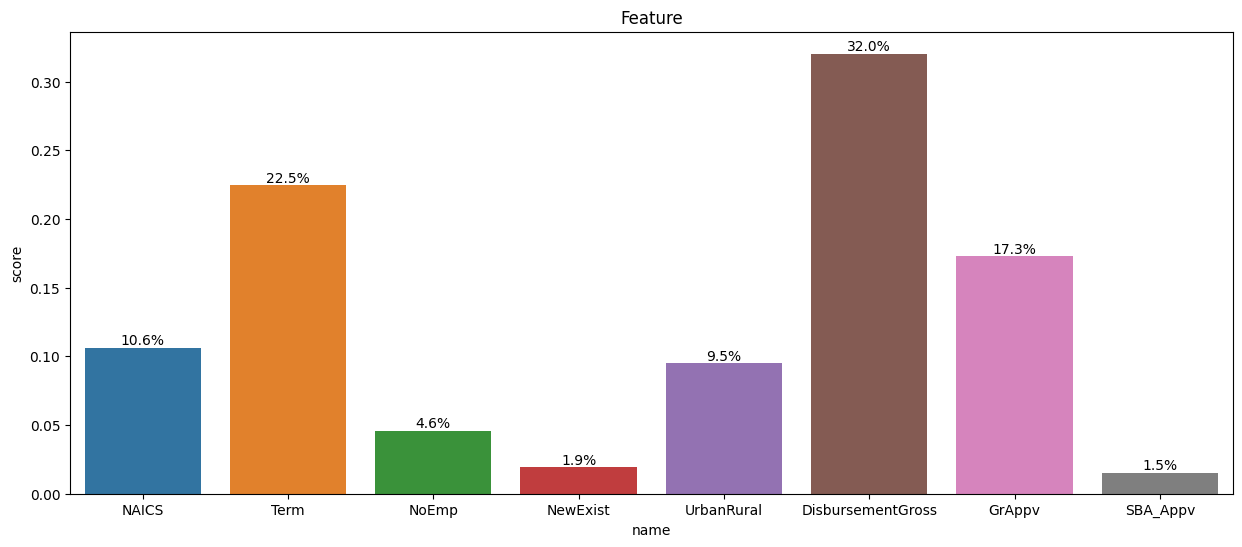

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
importance_cols = pd.DataFrame({"name" : model.feature_names_in_,
                                "score" : model.feature_importances_})

plot = sns.barplot(x=importance_cols['name'], y=importance_cols['score'])
plot.set_title("Feature")

for p in plot.patches:
    percentage = f'{p.get_height() * 100:.1f}%'  # Calculate the percentage value
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    plot.annotate(percentage, (x, y), ha='center', va='bottom')
plt.show()  

## Cây quyết định

In [25]:
pip install load_iris


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement load_iris (from versions: none)
ERROR: No matching distribution found for load_iris

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
!pip install graphviz


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
from sklearn.tree import DecisionTreeClassifier

# Xác định và khởi tạo mô hình Random Forest
DT_new = DecisionTreeClassifier()

# Huấn luyện mô hình với dữ liệu huấn luyện (X_train, y_train)
DT_new.fit(X_train, Y_train)

# tree_new = DT_new.feature_importances_[0]

DecisionTreeClassifier()

In [28]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import export_graphviz

dot_data = export_graphviz(DT_new, out_file='tree_new_DT.dot', feature_names = [str(x) for x in X],
                          class_names = [str(x) for x in Y.unique()], rounded = True, proportion = False, precision = 2,
                           # Thiết lập kích thước của biểu đồ Graphviz
                           max_depth=3,  # Số tầng sâu tối đa của cây quyết định
                           filled=True,  # Tô màu các node 
                           impurity=False,  # Không hiển thị thông tin entropy/impurity
                           rotate=False,  # Xoay biểu đồ
)

In [29]:
pip install graphviz


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


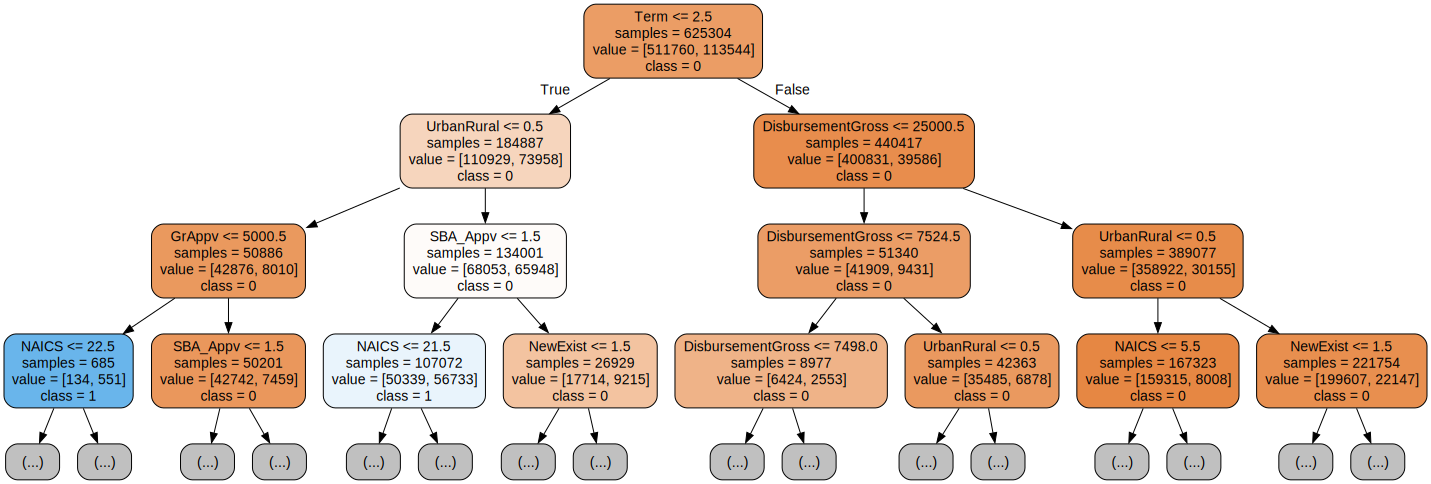

In [30]:
import graphviz
with open("tree_new_DT.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [31]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz
clf= tree.DecisionTreeClassifier(criterion="gini", random_state=0)
clf.fit(X,Y)

DecisionTreeClassifier(random_state=0)

In [32]:
# fig, ax = plt.subplots(figsize =  (50,24))
# tree.plot_tree(clf, filled= True, fontsize=10)
# plt.savefig('decision_tree', dpi=100)
# plt.show()

In [33]:
# nodes = clf.tree_.node_count  # Số lượng nút trong cây
# # parent_indices = clf.tree_.parent  # Mảng các chỉ số của nút cha
# left_child_indices = clf.tree_.children_left  # Mảng các chỉ số của nút con trái
# right_child_indices = clf.tree_.children_right  # Mảng các chỉ số của nút con phải
# feature_indices = clf.tree_.feature  # Mảng các chỉ số của đặc trưng
# thresholds = clf.tree_.threshold  # Mảng các ngưỡng
# node_classes = clf.tree_.value  # Mảng các lớp tại mỗi nút
# feature_importances = clf.feature_importances_  # Mảng độ quan trọng của các đặc trưng


In [34]:
new = {'NAICS': 42, 'Term': 1, 'NoEmp': 7, 'NewExist':2, 'UrbanRural':1,
       'DisbursementGross':2000, 'GrAppv':6000, 'SBA_Appv':2}

In [35]:
DT_new.predict(pd.DataFrame([new]))

array([0.])

In [36]:
X_pred = model.predict(X_test)

In [37]:
from sklearn.metrics import f1_score, accuracy_score
#f1_score(Y_test, X_pred, average='micro')


print('F1-score', f1_score(Y_test, X_pred, average='micro'))
print('Accuracy-score', accuracy_score(Y_test, X_pred))


F1-score 0.9222577130319267
Accuracy-score 0.9222577130319268
